## Processing User Data with the New Fields ##

In [1]:
# install the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta

Data generation complete with 771303 records.


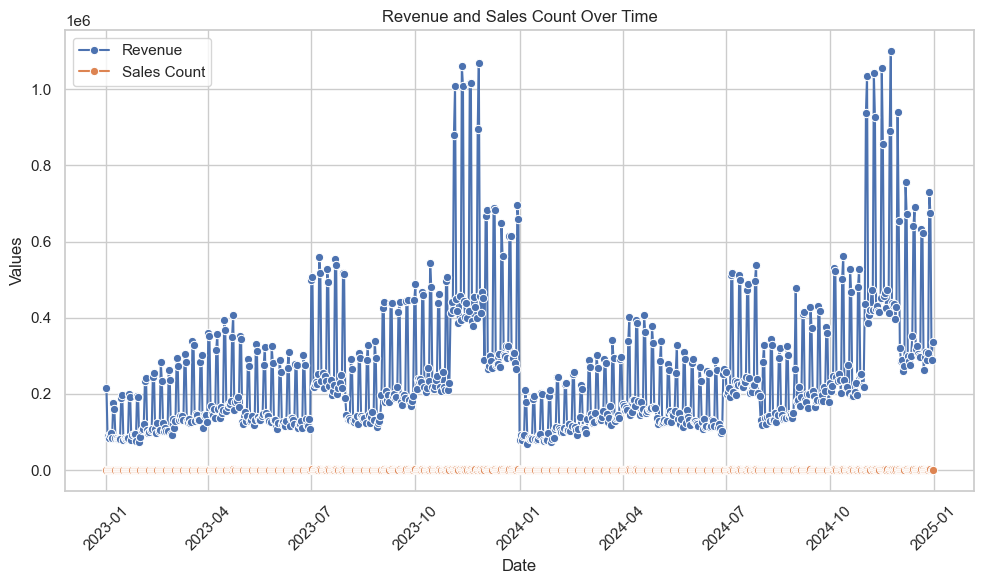

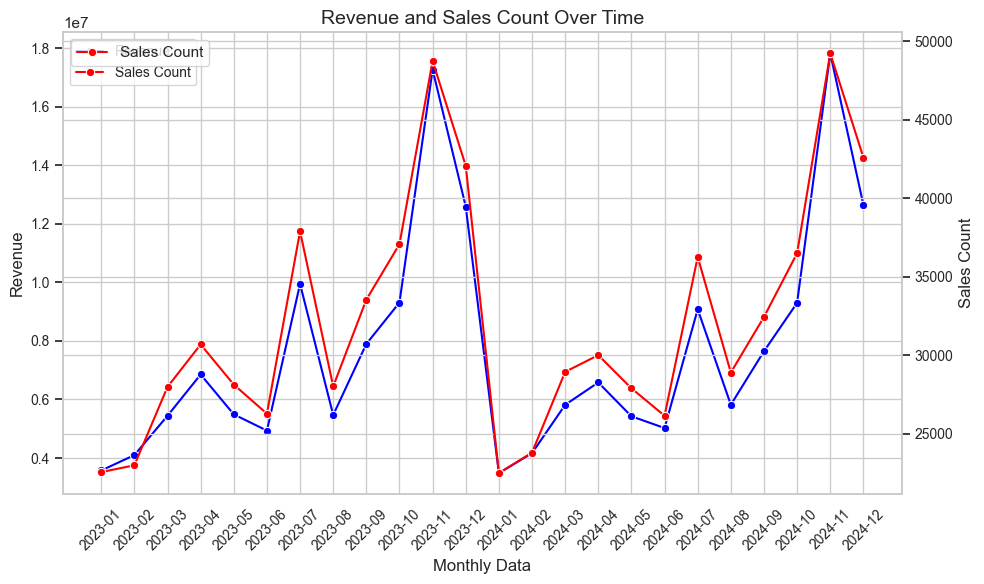

In [2]:
import import_ipynb
import Alternative_Data_Generation
userdata = User_Data_Generation.users

In [3]:
# Read from CSV

# userdata = pd.read_csv("data uploaded/user_data.csv")

# Process data: convert fields into the right data types

user_data = userdata.copy()
user_data["timestamp"] = pd.to_datetime(user_data["timestamp"])

# add new date column 

user_data["Date"] = pd.to_datetime(user_data["timestamp"]).dt.normalize()

In [4]:
user_data.head()

,timestamp,user_id,action,category,product_name,price,Date
0,2023-01-01 23:52:51,e9252ae4-fd02-4865-99be-ccc115f0d9cc,purchase,Home,Coffee Maker,62.18,2023-01-01
1,2023-01-01 11:59:01,3ef53f07-4685-4f98-bf92-e3a0eb4d6602,"click, click, click, click, view",Clothing,Skirt,49.25,2023-01-01
2,2023-01-01 14:32:18,5aa24c02-a7a7-4c2e-94b2-374783b108a2,purchase,Home,Slow Cooker,82.83,2023-01-01
3,2023-01-01 07:57:07,810e6f9a-1e40-4ff4-a2c9-c0fe76e6d484,"view, click, click, click, view",Home,Slow Cooker,69.08,2023-01-01
4,2023-01-01 09:14:59,29b1a5cf-1792-43fa-8438-2011a25489af,"view, click, purchase",Books,1984,17.05,2023-01-01


In [5]:
# Tackling "Action" field: extracting user actions to define attribution 

# Function to extract interactions
def extract_interactions(history, position):
    # Split the history string into a list
    entries = history.split(", ")
    # Check if the requested position exists (from the end)
    if len(entries) >= position:
        return entries[-position]
    return None  # Return None if the position doesn't exist

# Apply the function to create the columns
user_data["Last Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 1))
user_data["Third Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 2))
user_data["Second Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 3))
user_data["First Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 4))

In [6]:
# Create a new field "Sales_Channel" for attribution & further insights on the MMM

# Define probabilities for Sales_Channel when Last Interaction is "purchase"
sales_channel_probs = {
    "Search": 0.4,
    "Social": 0.25,
    "Video": 0.15,
    "Display": 0.10,
    "Digital Audio": 0.10
}

# Function to determine Sales_Channel
def determine_sales_channel(last_interaction):
    if last_interaction in ["view", "click"]:
        return "Offline"
    else:
        return np.random.choice(
            list(sales_channel_probs.keys()), 
            p=list(sales_channel_probs.values())
        )

# Apply the function to create the Sales_Channel column
user_data["Sales_Channel"] = user_data["Last Interaction"].apply(determine_sales_channel)

In [7]:
# Testing a new function in a copied dataframe
user_data2 = user_data.copy()

# Getting view counts and click counts out of the action section

click_probs = [0.35, 0.25, 0.15, 0.15, 0.1] # Search > Social > Video > Display > Audio
view_probs = [0.1, 0.2, 0.25, 0.3, 0.15]  # Display > Social > Video > Search > Audio
categories = ["Search", "Social", "Video", "Display", "Audio"]

# Function to distribute actions
def distribute_actions(actions):
    purchases = actions.count("purchase")
    clicks = actions.count("click") + purchases  # Purchases include 1 click each
    views = actions.count("view") + clicks  # Clicks (and purchases) include 1 view each
    
    # Distribute views and clicks based on probabilities
    view_distribution = np.random.multinomial(views, view_probs)
    click_distribution = np.random.multinomial(clicks, click_probs)
    
    # Create output dictionary
    output = {f"{category}_Views": view_distribution[i] for i, category in enumerate(categories)}
    output.update({f"{category}_Clicks": click_distribution[i] for i, category in enumerate(categories)})
    return output

# Apply the function and expand the result into new columns
distributions = user_data2["action"].apply(distribute_actions)
distributions_user_data2 = pd.DataFrame(list(distributions))

# Add the new columns to the original DataFrame
user_data3 = pd.concat([user_data2, distributions_user_data2], axis=1)

In [26]:
# Feature Engineering

user_data3["Sales_Channel"].unique() # checking the number of unique values in Sales Channel
user_data3["category"].unique() # checking the number of unique values in Category
user_data4 = user_data3.copy()

# Import scikit-learn for OHE

from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop=None, sparse_output=False)

# OneHotEncode "category"
category_encoded = encoder.fit_transform(user_data4[["category"]])
category_col_encoded = encoder.get_feature_names_out(["category"])
user_data4[category_col_encoded] = category_encoded  # Add encoded columns without removing the original

# OneHotEncode "Sales_Channel"
saleschannel_encoded = encoder.fit_transform(user_data4[["Sales_Channel"]])
sales_cha_encoded = encoder.get_feature_names_out(["Sales_Channel"])
user_data4[sales_cha_encoded] = saleschannel_encoded  # Add encoded columns without removing the original

# Display updated columns
print(user_data4.columns)


Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')


In [27]:
ud = user_data4
ud.head()
ud.columns

Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')

## Joining User Data with the Macro & Spend Data ##

In [28]:
# importing other notebook to join macro table with the user data

import import_ipynb
import MMM_macro_data 
daily = MMM_macro_data.daily

In [40]:
# Bringing the sum of revenue and sales on a daily rollup 

# Define the feature fields for summation
feature_engineered_sum = [
    'Search_Views', 'Social_Views', 'Video_Views', 'Display_Views', 'Audio_Views',
    'Search_Clicks', 'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
    'category_Books', 'category_Clothing', 'category_Electronics', 'category_Home',
    'Sales_Channel_Digital Audio', 'Sales_Channel_Display', 'Sales_Channel_Offline',
    'Sales_Channel_Search', 'Sales_Channel_Social', 'Sales_Channel_Video'
]

# Base aggregation dictionary
agg_dictionary = {
    "revenue": ("price", "sum"),
    "salescount": ("user_id", "count"),
    "searchclicks": ("Search_Clicks", "sum"),
    "search_impr": ("Search_Views", "sum")
}

# Update the dictionary dynamically for all feature fields
agg_dictionary.update({field: (field, "sum") for field in feature_engineered_sum})


# Perform groupby operation
ud_join = ud.groupby("Date").agg(**agg_dictionary)

# check the values

ud_join.head()

,revenue,salescount,searchclicks,search_impr,Search_Views,Social_Views,Video_Views,Display_Views,Audio_Views,Search_Clicks,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,215391.29,1045,876,373,373,756,944,1067,554,876,...,252.0,264.0,265.0,264.0,92.0,110.0,33.0,407.0,269.0,134.0
2023-01-02,88421.02,692,664,332,332,711,845,1080,550,664,...,177.0,176.0,163.0,176.0,56.0,47.0,75.0,254.0,177.0,83.0
2023-01-03,83424.32,587,541,278,278,635,750,866,437,541,...,149.0,129.0,147.0,162.0,59.0,62.0,74.0,191.0,124.0,77.0
2023-01-04,91345.89,672,674,346,346,636,774,991,509,674,...,167.0,173.0,174.0,158.0,54.0,56.0,75.0,247.0,137.0,103.0
2023-01-05,96503.82,702,680,355,355,670,821,1033,511,680,...,165.0,174.0,183.0,180.0,54.0,70.0,82.0,233.0,168.0,95.0


In [30]:
mmm_1 = daily.merge(ud_join, on = "Date", how="left") # Joining the user data with the macro data

In [31]:
# Macro data exploration

mmm_1.head()


,Date,Month,Year,Weekday,Trend_Factor,Promo_Exists,Consumer_Index,Inflation_Rate,Budget_Factor,Search_Factor,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,1.05,0,110.7,8.7,1308288,0.54,...,252.0,264.0,265.0,264.0,92.0,110.0,33.0,407.0,269.0,134.0
1,2023-01-02,1,2023,0,1.05,0,110.7,8.7,1308288,0.54,...,177.0,176.0,163.0,176.0,56.0,47.0,75.0,254.0,177.0,83.0
2,2023-01-03,1,2023,1,1.05,0,110.7,8.7,1308288,0.54,...,149.0,129.0,147.0,162.0,59.0,62.0,74.0,191.0,124.0,77.0
3,2023-01-04,1,2023,2,1.05,0,110.7,8.7,1308288,0.54,...,167.0,173.0,174.0,158.0,54.0,56.0,75.0,247.0,137.0,103.0
4,2023-01-05,1,2023,3,1.05,0,110.7,8.7,1308288,0.54,...,165.0,174.0,183.0,180.0,54.0,70.0,82.0,233.0,168.0,95.0


## MMM Joined Table EDA

In [32]:
mmm_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 730
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         731 non-null    datetime64[ns]
 1   Month                        731 non-null    int64         
 2   Year                         731 non-null    int64         
 3   Weekday                      731 non-null    int64         
 4   Trend_Factor                 731 non-null    float64       
 5   Promo_Exists                 731 non-null    int64         
 6   Consumer_Index               731 non-null    float64       
 7   Inflation_Rate               731 non-null    float64       
 8   Budget_Factor                731 non-null    int64         
 9   Search_Factor                731 non-null    float64       
 10  Display_Factor               731 non-null    float64       
 11  Video_Factor                 731 non-null    

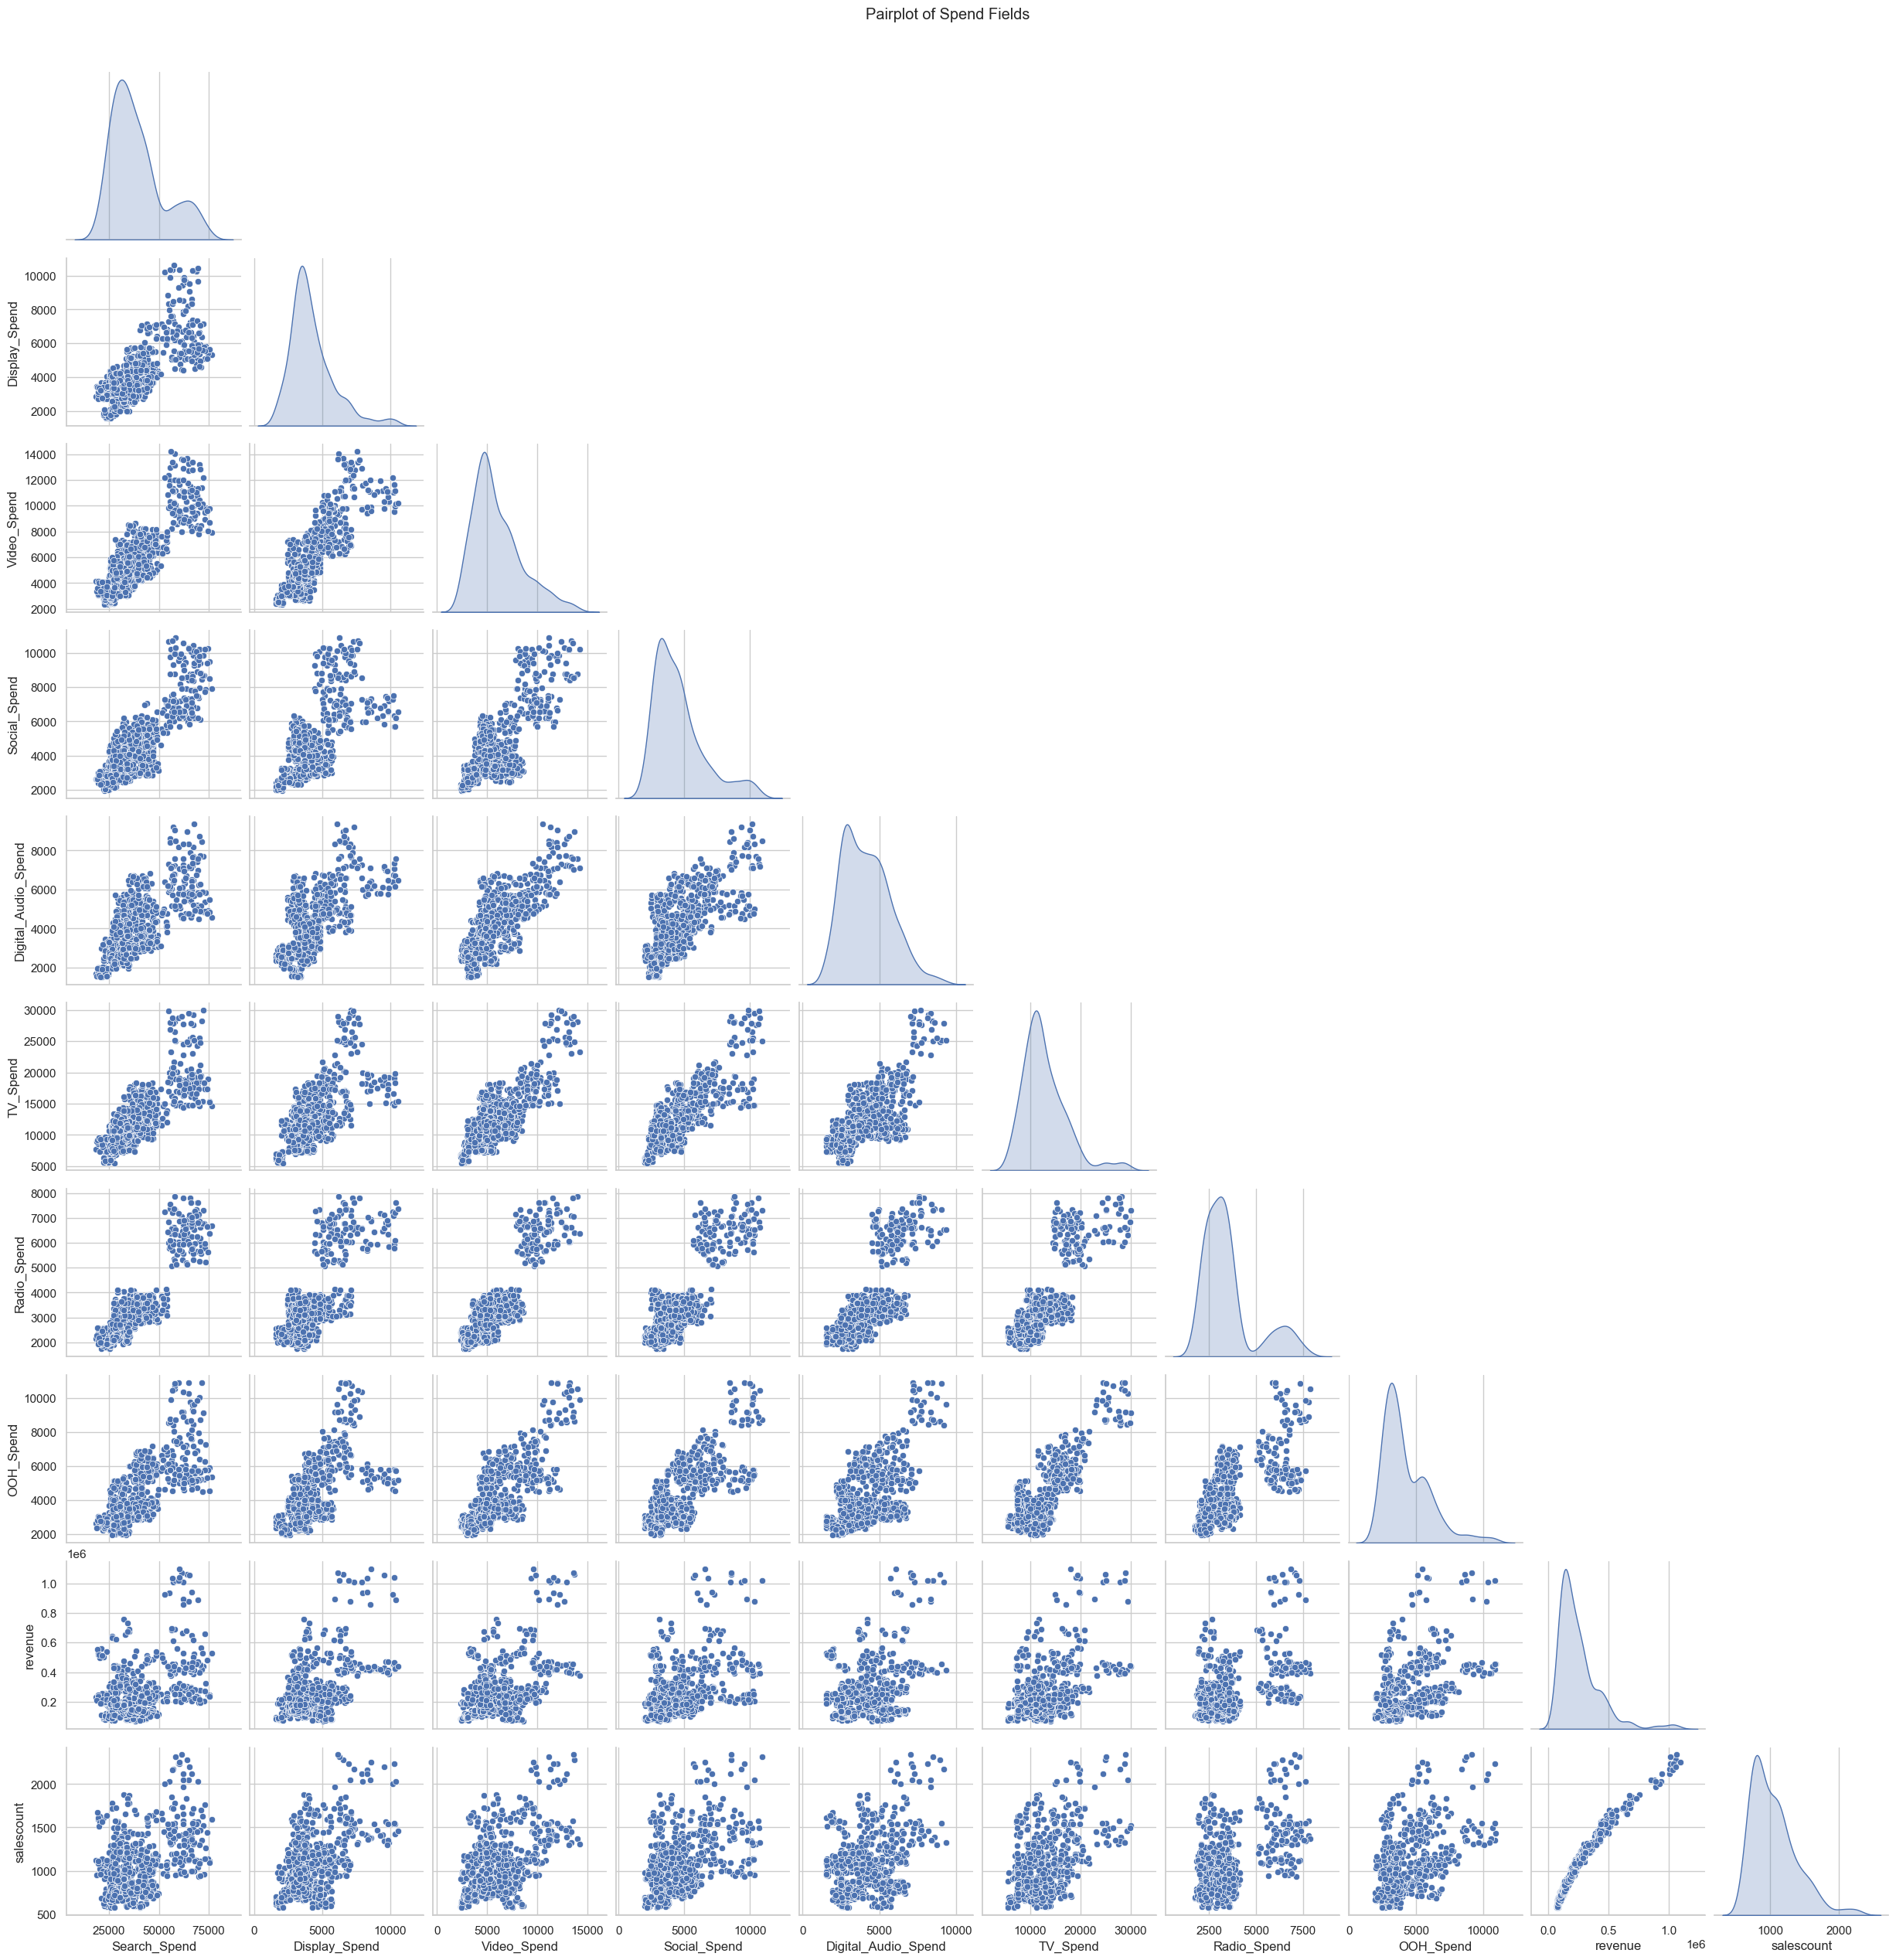

In [34]:
# Checking correlation & distribution

# Filter columns that contain 'Spend' in their names
spendc = [col for col in mmm_1.columns if "Spend" in col] + ["revenue", "salescount"]

# Create pairplot
sns.pairplot(mmm_1[spendc], diag_kind="kde", corner=True, height=2.5)

# Show the plot
plt.suptitle("Pairplot of Spend Fields", y=1.02)
plt.show()

<Axes: xlabel='Date', ylabel='salescount'>

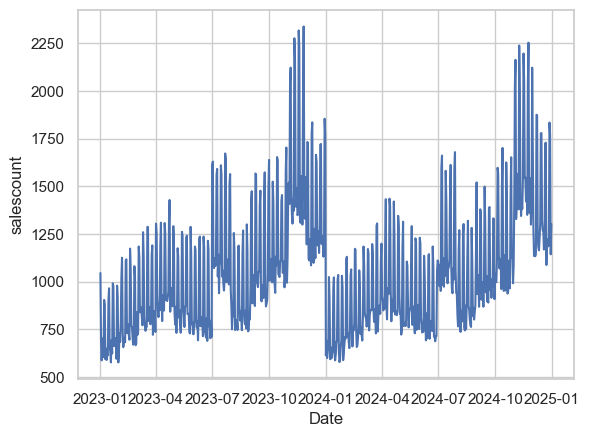

In [35]:
sns.lineplot(mmm_1, x="Date", y="salescount")

# Final Table

In [36]:
mmm = mmm_1.copy()

In [37]:
mmm.head()

,Date,Month,Year,Weekday,Trend_Factor,Promo_Exists,Consumer_Index,Inflation_Rate,Budget_Factor,Search_Factor,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,1.05,0,110.7,8.7,1308288,0.54,...,252.0,264.0,265.0,264.0,92.0,110.0,33.0,407.0,269.0,134.0
1,2023-01-02,1,2023,0,1.05,0,110.7,8.7,1308288,0.54,...,177.0,176.0,163.0,176.0,56.0,47.0,75.0,254.0,177.0,83.0
2,2023-01-03,1,2023,1,1.05,0,110.7,8.7,1308288,0.54,...,149.0,129.0,147.0,162.0,59.0,62.0,74.0,191.0,124.0,77.0
3,2023-01-04,1,2023,2,1.05,0,110.7,8.7,1308288,0.54,...,167.0,173.0,174.0,158.0,54.0,56.0,75.0,247.0,137.0,103.0
4,2023-01-05,1,2023,3,1.05,0,110.7,8.7,1308288,0.54,...,165.0,174.0,183.0,180.0,54.0,70.0,82.0,233.0,168.0,95.0


In [42]:
mmm.describe()

,Month,Year,Weekday,Trend_Factor,Promo_Exists,Consumer_Index,Inflation_Rate,Budget_Factor,Search_Factor,Display_Factor,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,7.310000e+02,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.00000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,6.519836,2023.500684,2.997264,1.457907,0.500684,113.667031,4.131874,1.630516e+06,0.493078,0.053735,...,264.415869,263.458276,263.971272,263.288646,99.76197,99.581395,58.231190,398.952120,248.415869,150.191518
std,3.451913,0.500342,2.004787,0.327242,0.500342,1.108149,2.252173,3.159924e+05,0.029488,0.011098,...,84.299056,84.796303,84.481840,83.656981,35.30867,35.092869,24.077555,137.365443,86.460614,52.390305
min,1.000000,2023.000000,0.000000,1.050000,0.000000,110.700000,1.600000,1.039161e+06,0.450000,0.040000,...,131.000000,129.000000,126.000000,128.000000,41.00000,38.000000,15.000000,191.000000,113.000000,61.000000
25%,4.000000,2023.000000,1.000000,1.250000,0.000000,113.200000,2.250000,1.369029e+06,0.460000,0.040000,...,199.000000,197.500000,202.000000,200.500000,71.00000,72.000000,37.000000,286.000000,177.500000,107.000000
50%,7.000000,2024.000000,3.000000,1.350000,1.000000,114.100000,2.900000,1.803617e+06,0.490000,0.050000,...,247.000000,248.000000,245.000000,249.000000,94.00000,93.000000,52.000000,383.000000,235.000000,143.000000
75%,10.000000,2024.000000,5.000000,1.700000,1.000000,114.500000,6.100000,1.909214e+06,0.520000,0.060000,...,308.000000,311.000000,309.000000,307.000000,120.00000,120.000000,79.500000,471.000000,297.000000,183.000000
max,12.000000,2024.000000,6.000000,2.300000,1.000000,115.100000,8.700000,1.971619e+06,0.540000,0.070000,...,612.000000,593.000000,613.000000,583.000000,238.00000,236.000000,127.000000,900.000000,596.000000,353.000000
